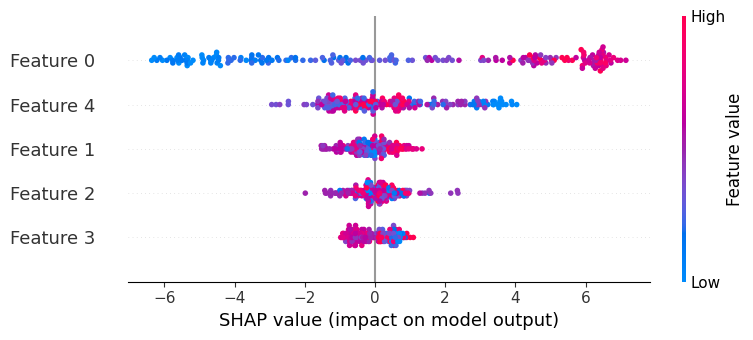

In [16]:
import shap
import xgboost
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Load dataset
X, y = make_classification(n_samples=1000, n_features=5, random_state=42)

# Define feature names manually
feature_names = [f"Feature {i}" for i in range(X.shape[1])]

# Convert to DataFrame
X_df = pd.DataFrame(X, columns=feature_names)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

# Train classifier
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)

# Create SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Shows the effect of a feature across all samples
shap.dependence_plot("Feature 0", shap_values.values, X_test)

# Shows the cumulative effect of features
shap.decision_plot(explainer.expected_value, shap_values.values, X_test)# Explains individual predictions

shap.force_plot(explainer.expected_value, shap_values.values[0], X_test[0]) # , feature_names=data.feature_names)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1721, number of negative: 6860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 8581, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200559 -> initscore=-1.382802
[LightGBM] [Info] Start training from score -1.382802


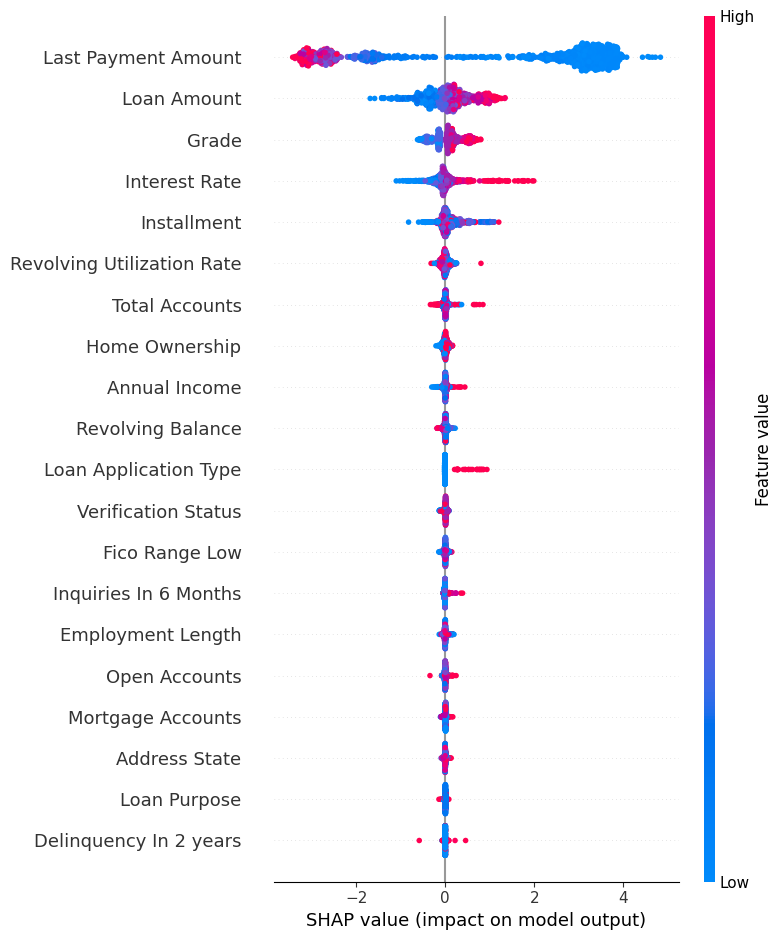

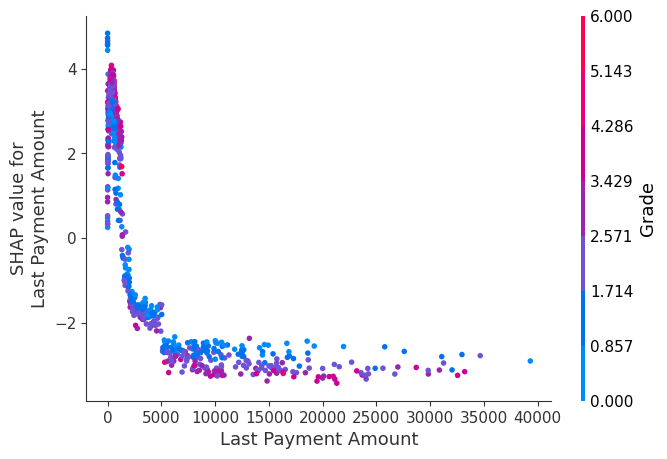

In [27]:
# Cell 1: Import Libraries and Setup
import os
import json
import logging
import numpy as np
import pandas as pd
import shap

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

from utils.helper import preprocess_combined_data

# Cell 2: Define Functions for SHAP Demonstration
def select_best_model(expert_systems_results, metric):
    best_model = None
    best_metric_value = -np.inf
    for result in expert_systems_results:
        if result[metric] > best_metric_value:
            best_metric_value = result[metric]
            best_model = result
    return best_model

def load_data(training_path, testing_path):
    logging.info("Loading training data from: %s", training_path)
    training_data = pd.read_parquet(training_path).dropna()

    logging.info("Loading testing data from: %s", testing_path)
    testing_data = pd.read_parquet(testing_path).dropna()

    return training_data, testing_data

def get_models():
    model_dict = {
        "Logistic Regression": (LogisticRegression, {"max_iter": 5000}),
        "Random Forest": (RandomForestClassifier, {"random_state": 0}),
        "XGBoost": (xgb.XGBClassifier, {
            "nthread": 10,
            "random_state": 0,
            "use_label_encoder": False,
            "eval_metric": "logloss"
        }),
        "LightGBM": (lgb.LGBMClassifier, {"random_state": 0}),
        "Naive Bayes": (GaussianNB, {})
    }
    return model_dict

def retrain_best_model(best_model_info, training_data, label_col="Loan Status"):
    best_model_name = best_model_info["model"]
    best_hparams = best_model_info.get("best_hyperparameters") or {}

    model_dict = get_models()
    model_class, default_params = model_dict[best_model_name]

    final_params = {**default_params, **best_hparams}

    trained_model = model_class(**final_params)
    feature_columns = [col for col in training_data.columns if col != label_col]

    X_train = training_data[feature_columns]
    y_train = training_data[label_col]
    trained_model.fit(X_train, y_train)

    logging.info(f"Retrained {best_model_name} with best hyperparameters: {best_hparams}")
    return trained_model, feature_columns

def demonstrate_shap(model, training_data, testing_data, feature_columns, label_col="Loan Status", draw_dependence=False):
    X_test = testing_data[feature_columns]
    y_test = testing_data[label_col]

    model_name = type(model).__name__.lower()
    if "xgb" in model_name or "lgbm" in model_name or "forest" in model_name:
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model, X_test)

    shap_values = explainer(X_test)

    # Summary Plot
    shap.summary_plot(shap_values, X_test)

    if draw_dependence:
        mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
        most_impactful_feature_idx = np.argmax(mean_abs_shap_values)
        most_impactful_feature = feature_columns[most_impactful_feature_idx]
        
        shap.dependence_plot(most_impactful_feature, shap_values.values, X_test)

# Cell 3: Load Data, Preprocess, and Train Model
# Provide paths to training and testing data
training_data_path = "datasets/prior/experts/train_expert.parquet"
testing_data_path = "datasets/prior/experts/test_expert_balanced.parquet"
metrics_json_path = "results/expert_systems/expert_systems_balanced.json"

# Load and preprocess data
training_data, testing_data = load_data(training_data_path, testing_data_path)
training_data, testing_data, mappings = preprocess_combined_data(
    training_data, testing_data, threshold=0, return_mapping=True
)

# Load model results from JSON
with open(metrics_json_path, 'r') as f:
    expert_systems_results = json.load(f)

# Select best model
output_metric = "ROC_AUC"
best_model_info = select_best_model(expert_systems_results, output_metric)

# Retrain best model
best_model, feature_columns = retrain_best_model(
    best_model_info, training_data, label_col="Loan Status"
)

# Cell 4: Demonstrate SHAP Interpretability
draw_dependence = True  # Set to True to draw dependence plot

demonstrate_shap(
    model=best_model,
    training_data=training_data,
    testing_data=testing_data,
    feature_columns=feature_columns,
    label_col="Loan Status",
    draw_dependence=draw_dependence
)
